# Measuring Fairness and Addressing Model Bias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import xgboost
from xgboost.sklearn import XGBClassifier

import aif360

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

## Create binary classes for each protected feature

In [3]:
train_main = pd.read_csv('data/application_train.csv', na_values=['','XNA','XAP'])

In [4]:
# missing value treatment
train_main = train_main[train_main['NAME_FAMILY_STATUS'] != 'Unknown']
train_main.shape

(307509, 122)

In [5]:
print(train_main['CODE_GENDER'].value_counts())
train_main.groupby(['CODE_GENDER'])['TARGET'].mean()

F    202447
M    105058
Name: CODE_GENDER, dtype: int64


CODE_GENDER
F    0.069994
M    0.101420
Name: TARGET, dtype: float64

In [6]:
def ismale(gender):
    """return 1 if male; 0 if female"""
    if gender == 'M':
        return 1
    else:
        return 0

train_main['IsMale'] = train_main['CODE_GENDER'].map(ismale)
train_main['IsMale'].value_counts() # a few nas got coded as female
# the treatment for those nas was going to be filled with female anyway, so good

0    202451
1    105058
Name: IsMale, dtype: int64

In [7]:
train_main.groupby(['CODE_GENDER'])['TARGET'].mean()

CODE_GENDER
F    0.069994
M    0.101420
Name: TARGET, dtype: float64

In [8]:
print(train_main['NAME_FAMILY_STATUS'].value_counts())
train_main.groupby(['NAME_FAMILY_STATUS'])['TARGET'].mean()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Name: NAME_FAMILY_STATUS, dtype: int64


NAME_FAMILY_STATUS
Civil marriage          0.099446
Married                 0.075599
Separated               0.081942
Single / not married    0.098077
Widow                   0.058242
Name: TARGET, dtype: float64

This shows that male is the group more likely to get unfavorable outcome.

In [9]:
# Binarize family status
def marital_status(status):
    if status in ["Single / not married", "Widow"]:
        return 1
    else:
        return 0

train_main['IsSingle'] = train_main['NAME_FAMILY_STATUS'].map(marital_status)
train_main['IsSingle'].value_counts()

0    245977
1     61532
Name: IsSingle, dtype: int64

In [79]:
train_main.groupby(['IsSingle'])['TARGET'].mean()

IsSingle
0    0.078995
1    0.087662
Name: TARGET, dtype: float64

In [11]:
# Propose: Bin ages into <= 30 and >30
train_main['Age'] = -train_main['DAYS_BIRTH']/365

def under30(age):    
    if age <= 30:
        return 1
    else:
        return 0

train_main['IsYoung'] = train_main['Age'].map(under30)
train_main['IsYoung'].value_counts()

0    262488
1     45021
Name: IsYoung, dtype: int64

In [12]:
train_main.groupby(['IsYoung'])['TARGET'].mean()

IsYoung
0    0.074925
1    0.114569
Name: TARGET, dtype: float64

In [13]:
# Drop original columns
train_main = train_main.drop(columns=['CODE_GENDER','NAME_FAMILY_STATUS','DAYS_BIRTH','Age'])
train_main.shape

(307509, 122)

In [14]:
# data cleaning
# remove columns with more than 100000 missing values
na_sum = train_main.isna().sum().sort_values(ascending=False)
drop_cols = na_sum[na_sum>100000]
train_data = train_main.drop(columns=drop_cols.index)

# drop rows with missing values
train_data.dropna(inplace=True)

# convert object datatype to categorical datatype
train_data[train_data.select_dtypes(['object']).columns] = train_data.select_dtypes(['object']).apply(lambda x: x.astype('category'))

train_data.shape

(167732, 73)

In [15]:
# convert binary variables to categorical datatype
binary_cols = ['CNT_CHILDREN','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
flag_cols = [col for col in train_data .columns if 'FLAG_DOCUMENT_' in col]
binary_cols.extend(flag_cols)

train_data[binary_cols] = train_data[binary_cols].astype('category')

In [16]:
# place the protected features and the target variable at the end of the dataset
y = train_data['TARGET']
X_train_data = train_data.drop(columns=['SK_ID_CURR','IsSingle','IsMale','IsYoung','TARGET'])
protected_cols = ['IsSingle','IsMale','IsYoung','TARGET']
protected = train_data[protected_cols]

In [17]:
numeric_features = X_train_data.select_dtypes(['int64','float64']).columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = X_train_data.select_dtypes(['category']).columns
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder())
    ]
)

In [18]:
X_train_data[numeric_features] = numeric_transformer.fit_transform(X_train_data[numeric_features])
X_train_data[categorical_features] = categorical_transformer.fit_transform(X_train_data[categorical_features])
X_train_data

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,0.0,1.0,0.0,0.076859,-0.524397,-0.222011,-0.550879,6.0,5.0,4.0,1.0,-0.134728,0.767265,0.304600,0.500716,0.0,1.0,0.0,1.0,1.0,0.0,8.0,-1.357044,-0.101555,-0.061264,6.0,-0.679758,-0.125993,-0.248873,-0.222233,-0.306372,-0.615023,-0.524271,5.0,-1.367968,-1.844872,0.232129,4.166220,0.241231,5.264228,-0.150318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,-0.300471,-0.428749,-0.473353
2,1.0,1.0,1.0,0.0,-0.366730,-1.190007,-1.463318,-1.127866,6.0,5.0,4.0,1.0,-0.784080,0.939402,0.116137,0.226888,0.0,1.0,1.0,1.0,1.0,0.0,8.0,-1.357044,-0.101555,-0.061264,1.0,-0.985306,-0.125993,-0.248873,-0.222233,-0.306372,-0.615023,-0.524271,11.0,0.191546,1.168123,-0.585114,-0.316554,-0.583485,-0.271815,0.231774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,-0.300471,-0.428749,-1.024591
5,0.0,0.0,1.0,0.0,-0.263226,-0.318787,-0.027210,-0.274406,5.0,3.0,4.0,1.0,1.123470,0.369929,-0.102505,1.595361,0.0,1.0,1.0,1.0,1.0,0.0,8.0,-0.295127,-0.101555,-0.061264,6.0,1.153532,-0.125993,-0.248873,-0.222233,-0.306372,-0.615023,-0.524271,33.0,-0.882084,0.615033,-0.585114,-0.316554,-0.583485,-0.271815,-1.829607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,-0.300471,1.232911,-0.473353
6,0.0,1.0,1.0,1.0,-0.026645,2.304051,0.925942,2.237890,6.0,1.0,1.0,1.0,1.123470,-0.274331,1.054450,1.500753,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.766789,-0.101555,-0.061264,3.0,1.153532,-0.125993,-0.248873,-0.222233,-0.306372,-0.615023,-0.524271,5.0,1.086317,-0.044376,-0.176492,-0.316554,-0.171127,-0.271815,-0.662969,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,0.738462,1.232911,0.077885
7,0.0,1.0,1.0,0.0,0.594379,2.228750,0.979465,2.598507,6.0,3.0,1.0,1.0,-1.295771,0.845813,0.012359,0.328158,0.0,1.0,1.0,1.0,0.0,0.0,10.0,-0.295127,1.888406,1.948486,1.0,1.153532,-0.125993,-0.248873,-0.222233,-0.306372,1.625956,1.907412,33.0,1.034572,0.203704,0.232129,-0.316554,0.241231,-0.271815,-0.073660,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,-0.300471,-0.428749,-1.024591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,0.0,1.0,1.0,-0.278012,-0.969442,-1.195701,-0.887455,6.0,5.0,4.0,1.0,-0.714916,-2.616565,-1.242523,-1.105607,0.0,1.0,1.0,1.0,0.0,0.0,8.0,0.766789,-0.101555,-0.061264,1.0,1

In [19]:
feature_selector = SelectKBest(f_classif, k=17)
feature_selector.fit(X_train_data, y)
top_features = feature_selector.get_feature_names_out()
X = X_train_data[top_features]

c:\Users\S\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [16 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\S\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [20]:
top_features

array(['NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3'], dtype=object)

In [21]:
X = pd.concat((X, protected), axis=1)

In [22]:
X

,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,IsSingle,IsMale,IsYoung
0,0.0,-0.524397,-0.550879,5.0,4.0,-0.134728,0.767265,0.304600,0.500716,-0.101555,-0.061264,-0.306372,-0.615023,-1.367968,-1.844872,-0.150318,1.0,1,1,1
2,1.0,-1.190007,-1.127866,5.0,4.0,-0.784080,0.939402,0.116137,0.226888,-0.101555,-0.061264,-0.306372,-0.615023,0.191546,1.168123,0.231774,0.0,1,1,0
5,0.0,-0.318787,-0.274406,3.0,4.0,1.123470,0.369929,-0.102505,1.595361,-0.101555,-0.061264,-0.306372,-0.615023,-0.882084,0.615033,-1.829607,1.0,0,1,0
6,0.0,2.304051,2.237890,1.0,1.0,1.123470,-0.274331,1.054450,1.500753,-0.101555,-0.061264,-0.306372,-0.615023,1.086317,-0.044376,-0.662969,0.0,0,0,0
7,0.0,2.228750,2.598507,3.0,1.0,-1.295771,0.845813,0.012359,0.328158,1.888406,1.948486,-0.306372,1.625956,1.034572,0.203704,-0.073660,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,-0.969442,-0.887455,5.0,4.0,-0.714916,-2.616565,-1.242523,-1.105607,-0.101555,-0.061264,-0.306372,1.625956,-1.099756,1.196989,-0.607871,1.0,0,0,0
307503,0.0,-0.674106,-0.827352,1.0,1.0,0.161401,0.866703,1.220125,-0.709190,-0.101555,-0.061264,-0.306372,-0.615023,-0.099588,0.554023,-1.564898,1.0,1,0,0
307508,0.0,0.139911,0.074190,5.0,1.0,-1.156556,-2.276051,-0.646647,-1.518015,1.888406,1.948486,-0.306372,1.625956,0.084068,-1.439100,-1.078599,1.0,0,0,0
307509,0.0,-0.613825,-0.635023,1.0,4.0,-1.133526,-0.966222,0.639030,1.292884,-0.101555,-0.061264,3.264004,1.625956,-0.030695,0.818202,0.822280,1.0,0,0,0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state =1)
print(X_train.shape, X_val.shape, X_test.shape)

(93929, 20) (40256, 20) (33547, 20)


In [24]:
X_train

,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,IsSingle,IsMale,IsYoung
213325,0.0,-0.115591,-0.166221,1.0,4.0,-0.191895,0.571731,-1.323513,0.983745,1.888406,1.948486,-0.306372,-0.615023,-1.459582,0.979195,1.207965,1.0,0,0,0
20216,0.0,1.520549,1.733027,1.0,1.0,1.895672,0.575909,1.403353,0.578667,-2.091516,-2.071013,3.264004,-0.615023,0.925528,-0.136314,1.206768,0.0,0,1,0
261761,0.0,1.558232,0.915629,3.0,4.0,-1.244232,-0.734756,-1.730003,0.224223,-0.101555,-0.061264,-0.306372,-0.615023,1.378429,0.148749,0.639019,1.0,0,0,0
280320,0.0,-0.992381,-1.007660,5.0,4.0,-0.714916,-3.618470,-0.512690,-0.342754,-0.101555,-0.061264,-0.306372,-0.615023,-0.412491,0.121215,1.207965,0.0,0,0,0
74941,0.0,-0.545075,-0.647043,5.0,4.0,-1.067324,-0.517078,-0.411068,-0.847103,-0.101555,-0.061264,3.264004,1.625956,-0.873607,-1.266855,0.890553,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23000,0.0,0.133383,0.314601,5.0,4.0,0.427392,-1.409935,-1.803294,1.374833,-0.101555,-0.061264,-0.306372,-0.615023,0.871049,-0.346081,-0.174274,1.0,0,0,0
34128,0.0,-0.890061,-0.851393,1.0,4.0,-0.899451,0.208655,-0.256171,-1.066299,-0.101555,-0.061264,-0.306372,-0.615023,0.310947,1.749988,-0.201823,1.0,0,0,0
283959,0.0,0.243323,0.326622,5.0,1.0,-0.112513,0.069943,0.715093,-0.911729,-0.101555,-0.061264,-0.306372,-0.615023,1.133383,1.695065,-1.786487,0.0,0,1,0
90721,0.0,0.788461,0.314601,1.0,4.0,1.895672,0.003093,0.105051,-0.469341,-2.091516,-2.071013,3.264004,1.625956,1.134408,0.931767,-0.714473,0.0,0,0,0


In [25]:
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer
from aif360 import datasets

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


## Fairness measure on the original train dataset

In [27]:
train = pd.concat((X_train, y_train), axis=1)
val = pd.concat((X_val, y_val), axis=1)

In [85]:
train_f = datasets.BinaryLabelDataset(favorable_label = 0, unfavorable_label = 1, df=train,
                                                      label_names=["TARGET"],
                                                     protected_attribute_names=["IsYoung","IsMale","IsSingle"],
                                              privileged_protected_attributes = [0,0,0])

In [86]:
# Disparate impact measurement for gender
fairness_metric = BinaryLabelDatasetMetric(
        train_f, unprivileged_groups=[{"IsMale":1}], privileged_groups=[{"IsMale":0}]) 
explainer = MetricTextExplainer(fairness_metric)

explainer.disparate_impact()

'Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9728775311516755'

In [76]:
# Disparate impact measurement for age
fairness_metric = BinaryLabelDatasetMetric(
        train_f, unprivileged_groups=[{"IsYoung":1}], privileged_groups=[{"IsYoung":0}]) 
explainer = MetricTextExplainer(fairness_metric)

explainer.disparate_impact()

'Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9614767617426325'

In [32]:
# Disparate impact measurement for marital status
fairness_metric = BinaryLabelDatasetMetric(
        train_f, unprivileged_groups=[{"IsSingle":1}], privileged_groups=[{"IsSingle":0}]) 
explainer = MetricTextExplainer(fairness_metric)

explainer.disparate_impact()

'Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9900862456687562'

## Fairness measure on predicted data

In [47]:
from xgboost.sklearn import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_val_pred = xgb_clf.predict(X_val)
X_val_pred = X_val.copy()
X_val_pred['TARGET'] = y_val_pred

In [48]:
pred_f = datasets.BinaryLabelDataset(favorable_label = 0.0, unfavorable_label = 1.0, df=X_val_pred,
                                                      label_names=["TARGET"],
                                                     protected_attribute_names=["IsYoung","IsMale","IsSingle"],
                                              privileged_protected_attributes = [0,0,0])

In [49]:
# fairness metric on gender
fairness_metric = BinaryLabelDatasetMetric(
        pred_f,
        unprivileged_groups=[{"IsMale":1}], #,{"IsYoung":1},{"IsSingle":1}
        privileged_groups=[{"IsMale":0}]) #,{"IsYoung":0},{"IsSingle":0}
explainer = MetricTextExplainer(fairness_metric)

print(explainer.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9946025503733853


In [50]:
# fairness metric for age
fairness_metric = BinaryLabelDatasetMetric(
        pred_f,
        unprivileged_groups=[{"IsYoung":1}], 
        privileged_groups=[{"IsYoung":0}]) 
explainer = MetricTextExplainer(fairness_metric)

print(explainer.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.994241126047575


In [51]:
# fairness metric for IsSingle
fairness_metric = BinaryLabelDatasetMetric(
        pred_f,
        unprivileged_groups=[{"IsSingle":1}], #,{"IsYoung":1},{"IsSingle":1}
        privileged_groups=[{"IsSingle":0}]) #,{"IsYoung":0},{"IsSingle":0}
explainer = MetricTextExplainer(fairness_metric)

print(explainer.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9987460095583376


## Removing Bias

In [52]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover

In [53]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [61]:
val_f = datasets.BinaryLabelDataset(favorable_label = 0.0, unfavorable_label = 1.0, df=val,
                                                      label_names=["TARGET"],
                                                     protected_attribute_names=["IsYoung","IsMale","IsSingle"],
                                              privileged_protected_attributes = [0,0,0])

In [100]:
thresh_arr = np.linspace(0.01, 1, 10)
val_metrics = test(dataset=val_f,
                   model=xgb_clf,
                   thresh_arr=thresh_arr)
orig_best_ind = np.argmax(val_metrics['bal_acc'])

c:\Users\S\AppData\Local\Programs\Python\Python310\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


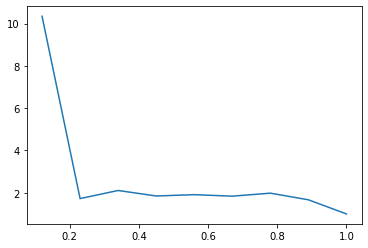

In [102]:
plt.plot(thresh_arr, val_metrics['disp_imp'])

In [67]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))

## Disparate impact remover

In [106]:
from aif360.datasets import BinaryLabelDataset

In [130]:
di = DisparateImpactRemover(repair_level=1.0)
rp_train = di.fit_transform(traindata)

In [125]:
df = aif360.datasets.BinaryLabelDataset(favorable_label=0.0, unfavorable_label=1.0, df=train, 
                                                      label_names=["TARGET"], 
                                                      protected_attribute_names=["IsYoung"],
                                                      privileged_protected_attributes = [0])

In [129]:
model = PrejudiceRemover()
prmodel = model.fit(df)